In [1]:
from chebGreen.greenlearning.model import *
from chebGreen.chebpy2 import Chebfun2, Chebpy2Preferences
import matplotlib.pyplot as plt

# %env TF_MLC_LOGGING=1 
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
model = GreenNN()
dimension = 1
domain = [-1,1,-1,1]
layerConfig = [50,50,50,50]
activation = 'rational'
homogeneousBC = False
loadPath = 'savedModels/mean_condition/3.00'
model.build(dimension, domain, layerConfig, activation, homogeneousBC, loadPath)

In [3]:
%%time
cheb2prefs = Chebpy2Preferences()
# cheb2prefs.prefx.eps = 1e-6
# cheb2prefs.prefx.eps = 1e-6
g = Chebfun2(model.evaluateG, domain = domain, prefs = cheb2prefs, simplify = False)

CPU times: user 1.38 s, sys: 93.8 ms, total: 1.48 s
Wall time: 1.42 s


In [4]:
from chebGreen.greenlearning.utils import DataProcessor
from chebGreen.utils import vec2cheb
from chebGreen.chebpy2.chebpy.api import chebfun
from chebGreen.chebpy2.chebpy.core.settings import ChebPreferences

In [5]:
data = DataProcessor('datasets/mean_condition/3.00')
data.generateDataset(trainRatio = 0.95)

In [6]:
def computeEmpiricalError(data):
    Error, UC, U0 = [],[],[]
    for i in range(data.valDataset[1].numpy().shape[0]):
        xF, xU = data.xF, data.xU
        f, u  = data.valDataset[0].numpy()[i,:], data.valDataset[1].numpy()[i,:] - model.evaluateN(xU).reshape(-1)
        f0, u0 = vec2cheb(f,xF), vec2cheb(u,xU)
        uc = g.integralTransform(f0)
        # prefs = ChebPreferences()
        # prefs.eps = 1e-8
        # un = chebfun(lambda x: model.evaluateN(x), domain = f0.domain, prefs = prefs)
        # uc = uc + un
        error = (uc - u0).abs()
        Error.append(error)
        UC.append(uc)
        U0.append(u0)
    return Error, UC, U0

In [7]:
Error, UC, U0 = computeEmpiricalError(data)

In [8]:
e = 0
for error,u0 in zip(Error,U0):
    e += error.sum()/np.abs(u0.sum())
e /= len(Error)
print(e)

582.1165620613053


In [9]:
np.mean(e)

582.1165620613053

Text(0.5, 1.0, 'Error = 6.88E-02')

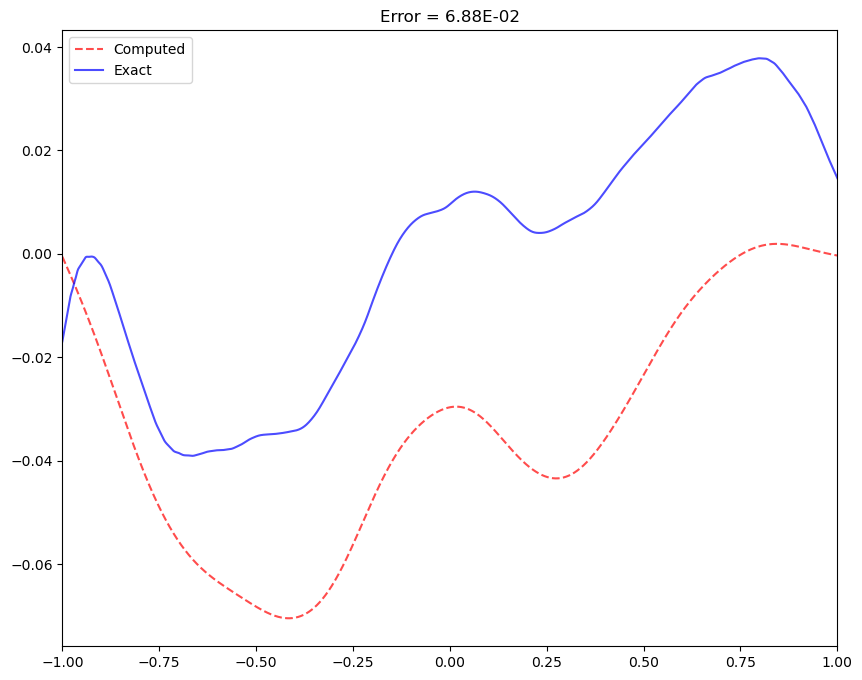

In [12]:
i = 3
error,uc,u0 = Error[i],UC[i],U0[i]
fig = plt.figure(figsize = (10,8))
uc.plot(fig = fig, color = 'red',linestyle ='--', alpha = 0.7)
u0.plot(fig = fig, color = 'blue',linestyle ='-', alpha = 0.7)
plt.legend(['Computed','Exact'])
plt.xlim([u0.domain[0],u0.domain[1]])
plt.title(f'Error = {error.sum():.2E}')